## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold # to use because of severe class imbalance
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

## Data exploration
review dataset to gain better understanding

In [2]:
# check for Nan values
train_data.isna().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [3]:
print(train_data['V4'].value_counts(),'\n')
print(train_data['V7'].value_counts(),'\n\n')
print(train_data['purchase'].value_counts(), '\n')
print(train_data['Promotion'].value_counts())

2    57450
1    27084
Name: V4, dtype: int64 

2    59317
1    25217
Name: V7, dtype: int64 


0    83494
1     1040
Name: purchase, dtype: int64 

Yes    42364
No     42170
Name: Promotion, dtype: int64


### Based on observations from the dataset, it appears that:
 - V1 represents a ordinal data and should be one-hot-coded
 - V2 represents age
 - V3 represents some normalized value like annual spend or member points
 - V4, V7 represent a binary outcome and should be one-hot-coded
 - V5,V6 could be ordinal data and may be used as is

In [3]:
#adopt Promotion column mapping Yes/No with quant. values
train_data['Promotion']=train_data['Promotion'].map({'Yes': 1, 'No': 0})
# drop User ID column as it will not be used in the further analysis
train_data.drop('ID', axis=1, inplace=True)
feature_order=[]

In [4]:
# Function to prepare the dataset
def prep_data(df):
    ''' This function prepares dataset for further processing'''
    
    #convert numeric values to strings for one hot coding for columns selected for one-hot coding
    df['V4'] = df['V4'].astype(str) 
    df['V7'] = df['V7'].astype(str)
    #one-hot encode selected columns
    dummies = pd.get_dummies(df[['V4', 'V7']],      # only these two cols
                         prefix=['V4', 'V7'],   # prepend the column name to dummy columns
                         drop_first=False)      # keep all categories; 

    # add dummies to df and, if you wish, remove the original categorical columns
    df_encode = pd.concat([df.drop(columns=['V4', 'V7']), dummies], axis=1)

    return df_encode

In [5]:
# Function to create interaction terms against Promotion variable in order to better capture the effect of promotion
def create_interaction(df):
    '''This function creates interaction terms for Promotion variable with key customer features V1-V7'''
    features = [col for col in df.columns if col.startswith('V')]
    for f in features:
        df['p_'+f]=df['Promotion']*df[f]
    return df

In [6]:
# Function to create and train the model
def build_model(df):
    '''Function to build and train the model. Uses GridSearchCV, returns best estimator.

    INPUT: dataframe that contains both explanatory variables (features) and prediction variable (purchase)'''
    #split the dataframe
    X_train= df.drop('purchase', axis=1)
    y_train=df['purchase']
    
    #create a pipieline
    pipeline= Pipeline([
    ('scaler',StandardScaler()),
    ('logistic',LogisticRegression(solver='saga', max_iter=500))
    ])

    #specify parameters to test
    param_grid={
        'logistic__C': np.logspace(-3,2,6),
        'logistic__penalty': ['l1','l2'],
        'logistic__class_weight': [None, 'balanced'],
    }

    #setup GridSearchCV:
    cv=GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc') #scoring='roc_auc' to force the model to separate classes properly

    #train the model
    cv.fit(X_train, y_train)

    #identify best model
    best_model=cv.best_estimator_

    return best_model

In [7]:
# Function to create predictions from the model based on promotion or not

def simulate_promotion(model, df, feature_order):
    '''Simulates promotion effect on user purchases. 
    Set promo=1 for all users to receive promo, set promo=0 for no promotion campaign.
    Model is your ML model.
    df is a set of V1 - V7 features.

    RETURNS a numpy array of the UPLIFT in predicted probabilities'''
    # get dummies for the V4 V7 columns
    data=df.copy()
    data_cleaned=prep_data(data)

    #promotions for all
    df_yes=data_cleaned.copy()
    df_yes['Promotion']=1
    df_yes=create_interaction(df_yes)
    df_yes=df_yes.reindex(columns=feature_order, fill_value=0)
    p_yes_preds=model.predict_proba(df_yes)[:,1]

    #promotions for NONE
    df_no=data_cleaned.copy()
    df_no['Promotion']=0
    df_no=create_interaction(df_no)
    df_no=df_no.reindex(columns=feature_order, fill_value=0)
    p_no_preds=model.predict_proba(df_no)[:,1]

    #calculate uplift
    uplift=p_yes_preds - p_no_preds

    return uplift

In [8]:
def select_for_promotion(df,price_per_sale=10,cost_per_promo=0.15):
    '''Decide on promotion allocation per user.
    Input - df with uplift in probability from promotion.
    price_per_sale=10 # earned when customer buys product
    cost_per_promo=0.15 #spent to send out promotion to the customer

    RETURNS a numpy array with Yes or No values'''
    
    #sort users by expected UPLIFT IN probability of purchase - from High to Low
    df_results=df.copy()
    
    #marginal profit method
    df_results['marginal_profit']=price_per_sale*df_results['uplift']-cost_per_promo
    marginal_method=df_results['marginal_profit'].apply(lambda x: 'No' if x <=0 else 'Yes')

    # breakeven method
    #BREAK_EVEN=cost_per_promo/price_per_sale
    #breakeven_method=np.where(df_results['uplift'] > BREAK_EVEN, 'Yes', 'No')

   
    return marginal_method



## Create the model using functions

In [9]:
train_data=prep_data(train_data) #create dummies
train_data=create_interaction(train_data) #create interaction terms
train_data.head()

,Promotion,purchase,V1,V2,V3,V5,V6,V4_1,V4_2,V7_1,V7_2,p_V1,p_V2,p_V3,p_V5,p_V6,p_V4_1,p_V4_2,p_V7_1,p_V7_2
0,0,0,2,30.443518,-1.165083,1,3,1,0,0,1,0,0.000000,-0.000000,0,0,0,0,0,0
1,0,0,3,32.159350,-0.645617,3,2,0,1,0,1,0,0.000000,-0.000000,0,0,0,0,0,0
2,0,0,2,30.431659,0.133583,1,4,1,0,0,1,0,0.000000,0.000000,0,0,0,0,0,0
3,0,0,0,26.588914,-0.212728,1,4,0,1,0,1,0,0.000000,-0.000000,0,0,0,0,0,0
4,1,0,3,28.044331,-0.385883,1,2,1,0,0,1,3,28.044331,-0.385883,1,2,1,0,0,1


In [10]:
# create and train our model
warnings.filterwarnings("ignore", category=ConvergenceWarning)
model=build_model(train_data);

In [11]:
#test dataset
# load in the data
test_data = pd.read_csv('./Test.csv')
#adopt Promotion column mapping Yes/No with quant. values
test_data['Promotion']=test_data['Promotion'].map({'Yes': 1, 'No': 0})
# drop User ID column as it will not be used in the further analysis
test_data.drop('ID', axis=1, inplace=True)
test_data=prep_data(test_data) #create dummies
test_data=create_interaction(test_data) #create interaction terms
test_data.head()

,Promotion,purchase,V1,V2,V3,V5,V6,V4_1,V4_2,V7_1,V7_2,p_V1,p_V2,p_V3,p_V5,p_V6,p_V4_1,p_V4_2,p_V7_1,p_V7_2
0,0,0,1,41.376390,1.172517,1,2,1,0,0,1,0,0.000000,0.000000,0,0,0,0,0,0
1,1,0,1,25.163598,0.653050,2,2,0,1,0,1,1,25.163598,0.653050,2,2,0,1,0,1
2,1,0,1,26.553778,-1.597972,3,4,0,1,0,1,1,26.553778,-1.597972,3,4,0,1,0,1
3,0,0,2,28.529691,-1.078506,3,2,0,1,0,1,0,0.000000,-0.000000,0,0,0,0,0,0
4,0,0,2,32.378538,0.479895,2,1,0,1,0,1,0,0.000000,0.000000,0,0,0,0,0,0


In [45]:
len(test_data)

41650

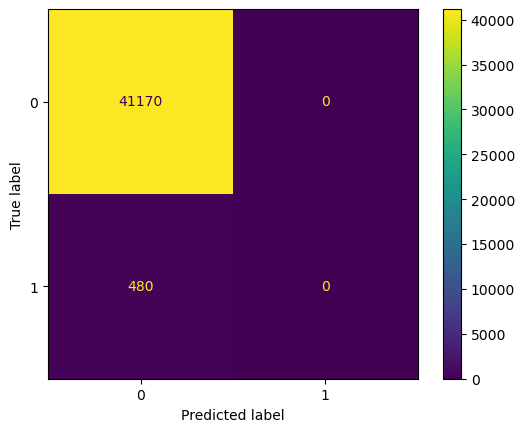

In [12]:
X_test=test_data.drop('purchase',axis=1)
y_test=test_data['purchase']
feature_order=X_test.columns.tolist()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred=model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
#Display the confusion matrix
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [13]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    results=df.copy()
    #simulate promotion to get uplift in probabilities
    uplift=simulate_promotion(model=model, df=df, feature_order=feature_order)
    results['uplift']=uplift
    print(results['uplift'].describe(percentiles=[.25,.5,.75,.95,.99]))

    #select users for promotion
    promotion=select_for_promotion(results)
    print('Overall, {} users out of {} were selected for pomotion, which represents {:.1%}'.format
          (sum(promotion=='Yes'),len(promotion),sum(promotion=='Yes')/len(promotion)))
    
    
    return promotion

In [14]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

#TEST RESULTS WITH MARGINAL METHOD
test_results(promotion_strategy)

count    41650.000000
mean         0.009466
std          0.007471
min         -0.004314
25%          0.001324
50%          0.010999
75%          0.015352
95%          0.020192
99%          0.023039
max          0.028153
Name: uplift, dtype: float64
Overall, 11277 users out of 41650 were selected for pomotion, which represents 27.1%
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0201.

Your nir with this strategy is 284.75.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020061605395205878, 284.75)

## Test if the promotion strategy resulst are statsistically significant

In [15]:
price_per_sale=10 # earned when customer buys product
cost_per_promo=0.15 #spent to send out promotion to the customer

# load in the data
check_data = pd.read_csv('./Test.csv')
check_data['Promotion']=check_data['Promotion'].map({'Yes': 1, 'No': 0})
# drop User ID column as it will not be used in the further analysis
check_data.drop('ID', axis=1, inplace=True)
check_data.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,0,0,1,41.376390,1.172517,1,1,2,2
1,1,0,1,25.163598,0.653050,2,2,2,2
2,1,0,1,26.553778,-1.597972,2,3,4,2
3,0,0,2,28.529691,-1.078506,2,3,2,2
4,0,0,2,32.378538,0.479895,2,2,1,2


In [16]:
check_data['send_flag']=promotion_strategy(check_data.drop(['Promotion','purchase'], axis=1))
check_data.head()

count    41650.000000
mean         0.009466
std          0.007471
min         -0.004314
25%          0.001324
50%          0.010999
75%          0.015352
95%          0.020192
99%          0.023039
max          0.028153
Name: uplift, dtype: float64
Overall, 11277 users out of 41650 were selected for pomotion, which represents 27.1%


,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,send_flag
0,0,0,1,41.376390,1.172517,1,1,2,2,No
1,1,0,1,25.163598,0.653050,2,2,2,2,No
2,1,0,1,26.553778,-1.597972,2,3,4,2,Yes
3,0,0,2,28.529691,-1.078506,2,3,2,2,Yes
4,0,0,2,32.378538,0.479895,2,2,1,2,No


In [17]:
check_data=check_data[check_data['send_flag']=='Yes']
check_data['profit_per_user']=(price_per_sale * check_data['purchase']-cost_per_promo*check_data['Promotion'])
check_data.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,send_flag,profit_per_user
2,1,0,1,26.553778,-1.597972,2,3,4,2,Yes,-0.15
3,0,0,2,28.529691,-1.078506,2,3,2,2,Yes,0.00
5,1,0,0,32.566788,-1.684550,2,1,2,1,Yes,-0.15
10,0,0,1,23.519509,-1.338239,2,1,2,2,Yes,0.00
11,0,0,2,40.824494,-1.597972,2,2,1,1,Yes,0.00


In [18]:
#check how many users in control vs treatment group
print(check_data[check_data['Promotion']==1].shape)
print(check_data[check_data['Promotion']==0].shape)
print(len(check_data))

(5635, 11)
(5642, 11)
11277


In [20]:
#check if the user split into control vs treatment group is random
n_obs=len(check_data)
n_treat=len(check_data[check_data['Promotion']==1])
n_control=len(check_data[check_data['Promotion']==0])
p_null=0.5
#null hypothesis: the proportion of users in the treatment group is 50%
#alternative hypothesis: the proportion of users in the treatment group is not 50%
#z-test
z=(n_treat/n_obs-p_null)/np.sqrt(p_null*(1-p_null)/n_obs) 
print('z-statistic:', z)
#p-value
p_value=2*(1-sp.stats.norm.cdf(abs(z)))
print('p-value:', p_value)

if p_value < 0.025:
    print('Reject H0: users split is not balanced at the 95% confidence level')
else:
    print('Fail to reject H0: there is no evidence the user split is not balanced at the 95% confidence level')


z-statistic: -0.06591757921947643
p-value: 0.9474434448284703
Fail to reject H0: there is no evidence the user split is not balanced at the 95% confidence level


In [21]:
observed_NIR_effect=check_data[check_data['Promotion']==1]['profit_per_user'].sum() - check_data[check_data['Promotion']==0]['profit_per_user'].sum()
print('Observed Net Incremental Revenue effect on the test set is ${:.2f}'.format(observed_NIR_effect))

Observed Net Incremental Revenue effect on the test set is $284.75


In [ ]:
## Use non-parametric test to check for significance

In [22]:
profits= check_data.copy()
n=len(profits)

#Bootstrap

n_trials=10_000
boot_NIR=np.empty(n_trials)

for t in range(n_trials):
    boot_sample = profits.sample(n=n, replace=True)
    NIR_effect=boot_sample[boot_sample['Promotion']==1]['profit_per_user'].sum() - boot_sample[boot_sample['Promotion']==0]['profit_per_user'].sum()

    boot_NIR[t]= NIR_effect

# Build a one-tailed 95% confidence interval
lower_bound = np.percentile(boot_NIR, 2.5)  # 5th percentile for one-tailed

# Check if the lower bound > 0
if lower_bound > 0:
    print('Reject H0: NIR is significantly > 0 at the 95% confidence level')
else:
    print('Fail to reject H0: evidence of profit is not statistically different from 0')

# Print the lower bound
print(f"One-tailed 95% lower bound for NIR: {lower_bound:.2f}")

Reject H0: NIR is significantly > 0 at the 95% confidence level
One-tailed 95% lower bound for NIR: 29.70


In [23]:
profits= check_data.copy()
n=len(profits)

#Bootstrap

n_trials=10_000
boot_NIR=np.empty(n_trials)

for t in range(n_trials):
    boot_sample = profits.sample(n=n, replace=True)
    NIR_effect=boot_sample[boot_sample['Promotion']==1]['profit_per_user'].sum() - boot_sample[boot_sample['Promotion']==0]['profit_per_user'].sum()

    boot_NIR[t]= NIR_effect
#use a one-tailed test to confirm if our strategy results in NIR > 0 at 95% confidence interval
alpha=0.05
p_one_tailed= (boot_NIR <= 0).mean()
if p_one_tailed < alpha:
    print('Reject H0: NIR is significantly > 0 at the 95% confidence level')
else:
    print('Fail to reject H0: evidence of profit is not statistically different from 0')

Reject H0: NIR is significantly > 0 at the 95% confidence level
